# Signal Decay

```{important}
This chapter should differentiate itself from TE_Dependence by focusing on the application of {eq}`monoexponential_decay`
to raw signal, rather than decompositions.
```

```{important}
The general flow of this chapter should be:

1.  Explain the monoexponential decay equation.
    1.  Mention other models of signal decay, including biexponential models,
        and why they generally aren't used on multi-echo fMRI data.
2.  Show signal decay in real data.
    1.  Start with single-volume brain images across increasing echo times.
    2.  Next, show a scatter plot of the values for a single voxel over time, separated by echo time,
        to give a better sense of the scale of the decay.
    3.  Line plots of the different echo times for a single voxel to show that decay is not a simple scalar.
3.  Show a simulated, static decay curve.
4.  Show the difference in decay curves for "active" and "inactive" states in the same voxel (i.e., different T2* values).
5.  Show how single-echo data fluctuate over time, given an underlying signal.
6.  Add a changing decay curve underneath the single-echo data point.
7.  Overlay points for the changing T2* and S0 values as well.
8.  Plot the decay curves of the same relative fluctuations, but dependent solely on S0 or T2* changes.
9.  Overlay single-echo data points on the fluctuating decay curves,
    to show how the two types of fluctuations cannot be dissociated using single-echo data.
    1.  Plot scaled T2* against the single-echo data in a line plot. The time series will be very similar, but slightly different.
    2.  Plot scaled S0 against the single-echo data. The time series will effectively be the same.
    3.  Point out that we don't know the underlying T2* or S0 fluctuations,
        so this just shows how very similar signal can come from T2* _or_ S0.
10. Overlay multi-echo data points on the fluctuating decay curves, to show how the differences in the patterns are much clearer.
11. Discuss the effect of noise on the multi-echo signal. Perhaps plot a single voxel's real values?
12. Point to the TE Dependence chapter.
```

In this chapter, we illustrate how BOLD signal decays and how we can glean useful information from that decay rate.

To do this, we will use a combination of simulated and real multi-echo data.

In [1]:
import os

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from IPython import display
from matplotlib.animation import FuncAnimation
from myst_nb import glue
from nilearn import image, masking, plotting
from nilearn.glm import first_level
from repo2data.repo2data import Repo2Data
from scipy import signal

from book_utils import predict_bold_signal

sns.set_style("whitegrid")

# Install the data if running locally, or point to cached data if running on neurolibre
DATA_REQ_FILE = os.path.join("../binder/data_requirement.json")

# Download data
repo2data = Repo2Data(DATA_REQ_FILE)
data_path = repo2data.install()
data_path = os.path.abspath(data_path[0])

out_dir = os.path.join(data_path, "signal-decay")
os.makedirs(out_dir, exist_ok=True)

---- repo2data starting ----
/opt/hostedtoolcache/Python/3.10.17/x64/lib/python3.10/site-packages/repo2data
Config from file :
../binder/data_requirement.json
Destination:
./../data/multi-echo-data-analysis

Info : ./../data/multi-echo-data-analysis already downloaded


In [2]:
func_dir = os.path.join(data_path, "func/")
data_files = [
    os.path.join(
        func_dir,
        "sub-04570_task-rest_echo-1_space-scanner_desc-partialPreproc_bold.nii.gz",
    ),
    os.path.join(
        func_dir,
        "sub-04570_task-rest_echo-2_space-scanner_desc-partialPreproc_bold.nii.gz",
    ),
    os.path.join(
        func_dir,
        "sub-04570_task-rest_echo-3_space-scanner_desc-partialPreproc_bold.nii.gz",
    ),
    os.path.join(
        func_dir,
        "sub-04570_task-rest_echo-4_space-scanner_desc-partialPreproc_bold.nii.gz",
    ),
]
ted_dir = os.path.join(data_path, "tedana")
ECHO_TIMES = [12, 28, 44, 60]
n_echoes = len(ECHO_TIMES)

pal = sns.color_palette("cubehelix", n_echoes)

img = image.index_img(data_files[0], 0)
data = img.get_fdata()
vmax = np.max(data)
idx = np.vstack(np.where(data > 1000))

min_x, min_y, min_z = np.min(idx, axis=1)
max_x, max_y, max_z = np.max(idx, axis=1)

imgs = []
for f in data_files:
    img = image.index_img(f, 0)
    data = img.get_fdata()
    data = data[min_x:max_x, min_y:max_y, min_z:max_z]
    img = nib.Nifti1Image(data, img.affine, img.header)
    imgs.append(img)

# Create binary mask from adaptive mask
adaptive_mask_file = os.path.join(
    ted_dir, "sub-04570_task-rest_space-scanner_desc-adaptiveGoodSignal_mask.nii.gz"
)
mask = image.math_img("img >= 3", img=adaptive_mask_file)

# Component parameter estimates
betas_file = os.path.join(
    ted_dir, "sub-04570_task-rest_space-scanner_desc-ICA_components.nii.gz"
)
beta_maps = masking.apply_mask(betas_file, mask)

# Component table
comp_tbl = pd.read_table(
    os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_desc-tedana_metrics.tsv"),
    index_col="Component",
)

# Get voxel index for voxel most related to component with highest kappa value
acc_comp_tbl = comp_tbl.loc[comp_tbl["classification"] == "accepted"]
high_kappa_comp = acc_comp_tbl.sort_values(by="kappa", ascending=False).index.values[0]
high_kappa_comp_val = int(high_kappa_comp.split("_")[1])
voxel_idx = np.where(
    beta_maps[high_kappa_comp_val, :] == np.max(beta_maps[high_kappa_comp_val, :])
)[0][0]

# Extract the time series for the high-kappa voxel
data = [masking.apply_mask(f, mask) for f in data_files]
ts = [d[:, voxel_idx] for d in data]
ts_1d = np.hstack(ts)

n_trs = ts[0].shape[0]

## Signal decays as echo time increases

To start, let us look at how BOLD signal changes with increasing echo time in real data.
The data we use is a single resting-state run, with echo times of 12, 28, 44, and 60 milliseconds.

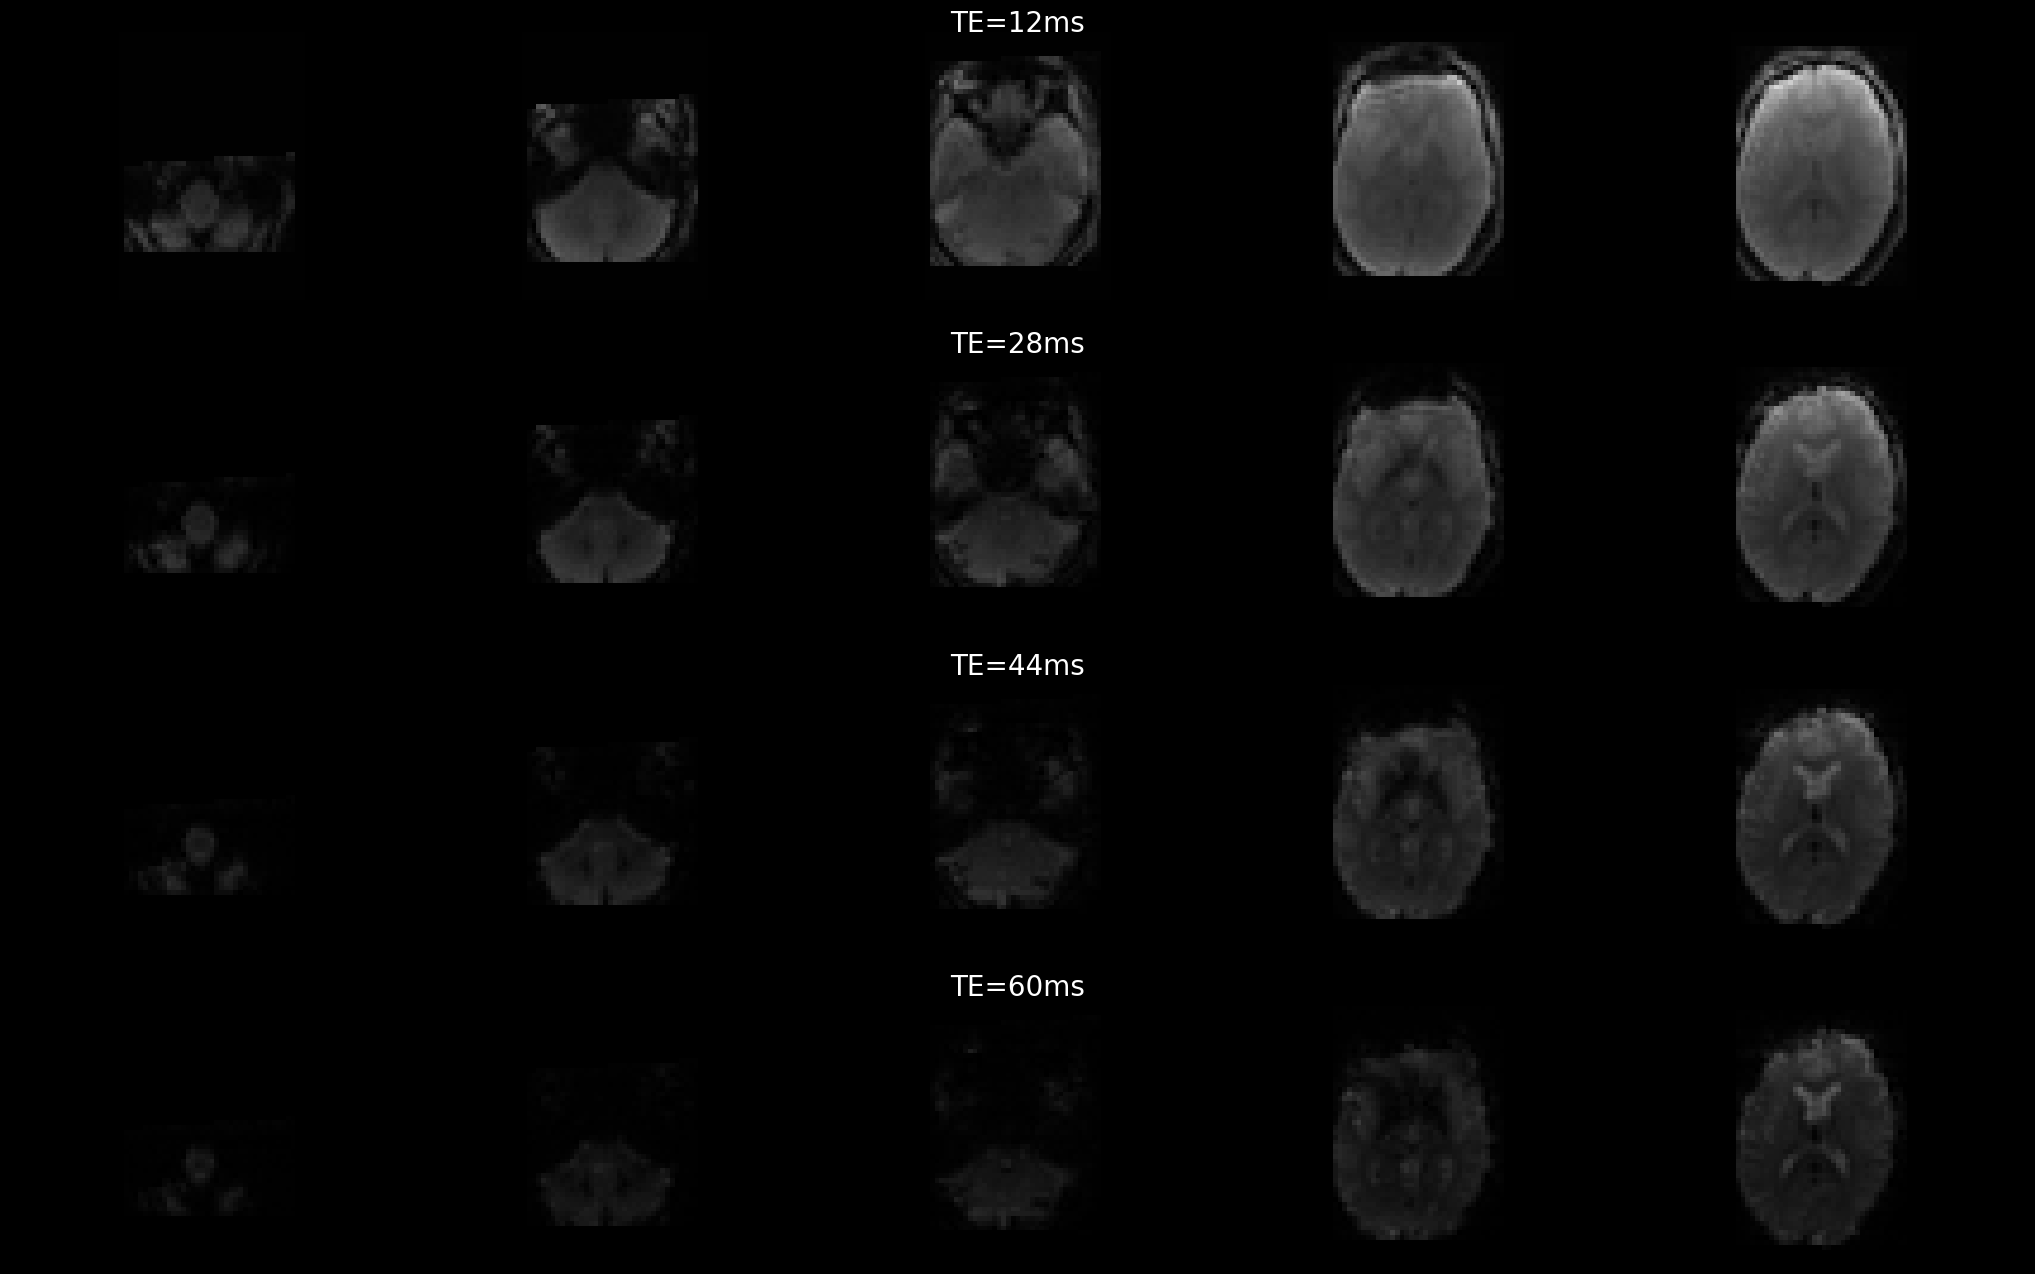

In [3]:
plt.style.use("dark_background")

fig, axes = plt.subplots(figsize=(26, 16), nrows=len(data_files))
for i_echo, img in enumerate(imgs):
    te = ECHO_TIMES[i_echo]
    if i_echo == 0:
        data = img.get_fdata()
        vmax = np.max(data)

    plotting.plot_epi(
        img,
        cut_coords=[-15, 0, 15, 30, 45],
        display_mode="z",
        annotate=False,
        draw_cross=False,
        axes=axes[i_echo],
        figure=fig,
        vmax=vmax,
        cmap="gray",
    )
    axes[i_echo].set_title("TE={}ms".format(te), fontsize=20, pad=0)

glue("fig_brain_decay", fig, display=False)

# Reset the style
plt.style.use("default")

```{glue:figure} fig_brain_decay
:name: fig_brain_decay
:align: center

Signal decay in the brain.
```

The nature of multi-echo (ME) acquisition leads to signal decay, with high signal-to-noise ratio (SNR) at short echo times (TE) and lower SNR at longer TEs. You may notice that the images appear darker as the signal decays with increasing TE. Additionally, image contrast tends to increase with longer echo times.

### Echo-specific data and echo time

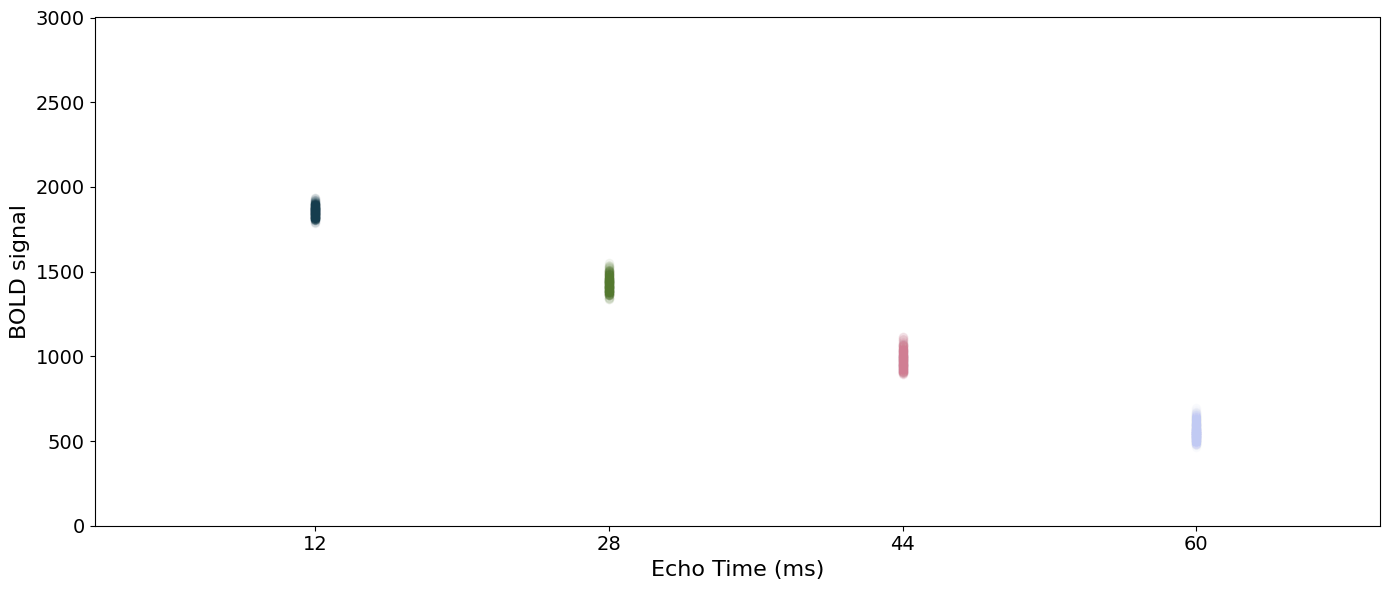

In [4]:
fig, ax = plt.subplots(figsize=(14, 6))
values = [i[0] for i in ts]
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * ECHO_TIMES[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.set_ylabel("BOLD signal", fontsize=16)
ax.set_xlabel("Echo Time (ms)", fontsize=16)
ax.set_xticks(ECHO_TIMES)
ax.tick_params(axis="both", which="major", labelsize=14)
ax.set_xlim(0, 70)
ax.set_ylim(0, 3000)
fig.tight_layout()
glue("fig_echo_scatter", fig, display=False)

```{glue:figure} fig_echo_scatter
:name: fig_echo_scatter
:align: center

Scatter plot of voxel's values by echo time.
```

Here, we visualize the temporal variation of a single voxel’s signal (y-axis) across four different echo times (TE) on the x-axis. As expected, the signal magnitude decreases with increasing TE.

### The signal itself changes with echo time as well

Let us visualize the time series of one voxel acquired at different echo times. While the overall scale of the signal decreases with echo time, the actual pattern of the signal changes as well.

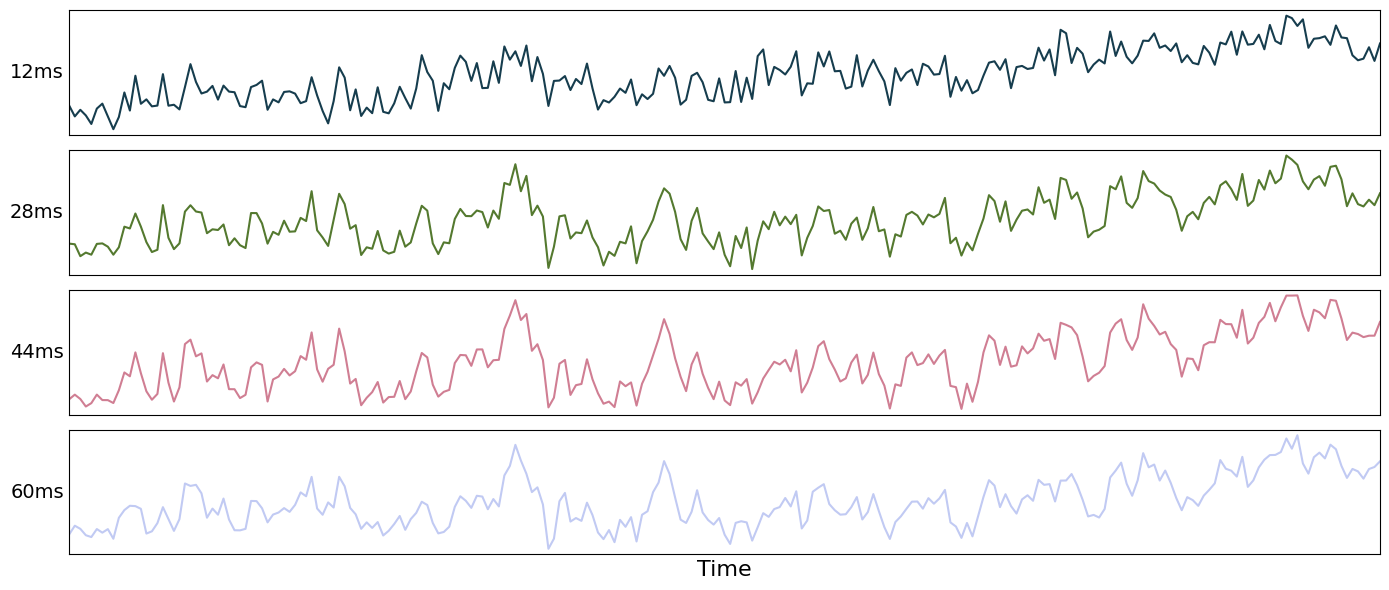

In [5]:
fig, axes = plt.subplots(n_echoes, sharex=True, sharey=False, figsize=(14, 6))
for i_echo in range(n_echoes):
    axes[i_echo].plot(ts[i_echo], color=pal[i_echo])
    axes[i_echo].set_ylabel(
        f"{ECHO_TIMES[i_echo]}ms", rotation=0, va="center", ha="right", fontsize=14
    )
    axes[i_echo].set_yticks([])
    axes[i_echo].set_xticks([])

axes[-1].set_xlabel("Time", fontsize=16)
axes[-1].set_xlim(0, len(ts[i_echo]) - 1)
fig.tight_layout()
glue("fig_echo_timeseries", fig, display=False)

```{glue:figure} fig_echo_timeseries
:name: fig_echo_timeseries
:align: center

Time series from a voxel for each echo.
```

## The impact of $T_{2}^{*}$ and $S_{0}$ fluctuations on BOLD signal

In this section, we investigate the two factors driving changes in the signal decay pattern: $T_{2}^{*}$ and $S_{0}$.

Firstly, let us run some code to simulate the signal decay curve.

In [6]:
# Simulate data
SINGLEECHO_TE = np.array([30])

# For a nice, smooth curve
FULLCURVE_TES = np.arange(0, 101, 1)

n_echoes = len(FULLCURVE_TES)
pal = sns.color_palette("cubehelix", 8)

### Simulate $T_{2}^{*}$ and $S_{0}$ fluctuations

In [7]:
# Simulate data
# We'll convolve with HRF just for smoothness
hrf = first_level.spm_hrf(1, oversampling=1)

N_VOLS = 21

SCALING_FRACTION = 0.1  # used to scale standard deviation
MEAN_T2S = 35
MEAN_S0 = 16000

# simulate the T2*/S0 time series
# The original time series will be a random time series from a normal distribution,
# convolved with the HRF
ts = np.random.normal(loc=0, scale=1, size=(N_VOLS + 20,))
ts = signal.convolve(ts, hrf)[20 : N_VOLS + 20]
ts *= SCALING_FRACTION / np.std(ts)
ts -= ts[0]

t2s_ts = (ts * MEAN_T2S) + MEAN_T2S
s0_ts = (ts * MEAN_S0) + MEAN_S0

#### Plot BOLD signal decay for a standard single-echo scan

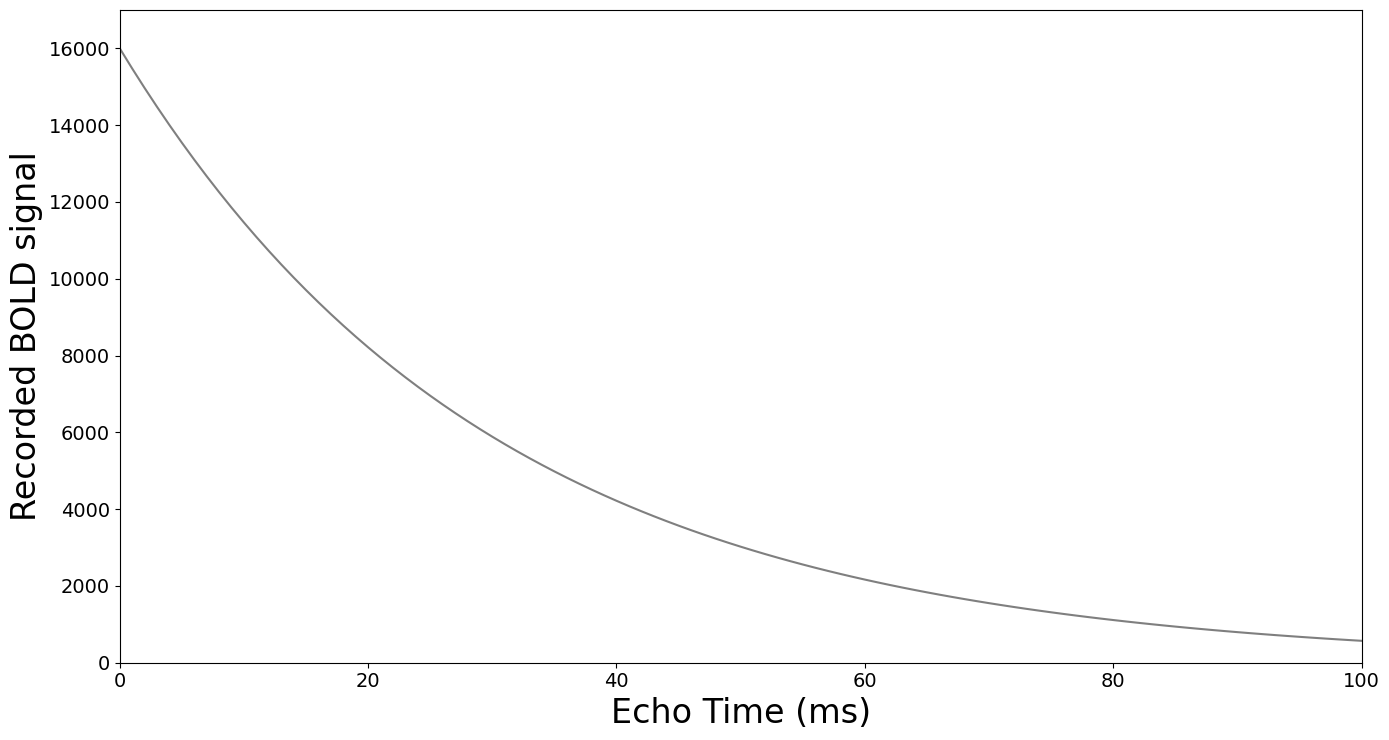

In [8]:
fullcurve_signal = predict_bold_signal(FULLCURVE_TES, [MEAN_S0], [30])

fig, ax = plt.subplots(figsize=(14, 7.5))
ax.plot(
    FULLCURVE_TES,
    fullcurve_signal[:, 0],
    alpha=0.5,
    color="black",
)

ax.set_ylabel("Recorded BOLD signal", fontsize=24)
ax.set_xlabel("Echo Time (ms)", fontsize=24)
ax.set_ylim(0, np.ceil(np.max(fullcurve_signal) / 1000) * 1000)
ax.set_xlim(0, np.max(FULLCURVE_TES))
ax.tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()
glue("fig_signal_decay_single-echo", fig, display=False)

```{glue:figure} fig_signal_decay_single-echo
:name: fig_signal_decay_single-echo
:align: center

BOLD signal decay for a standard single-echo scan
```

### Plot BOLD signal decay and BOLD contrast

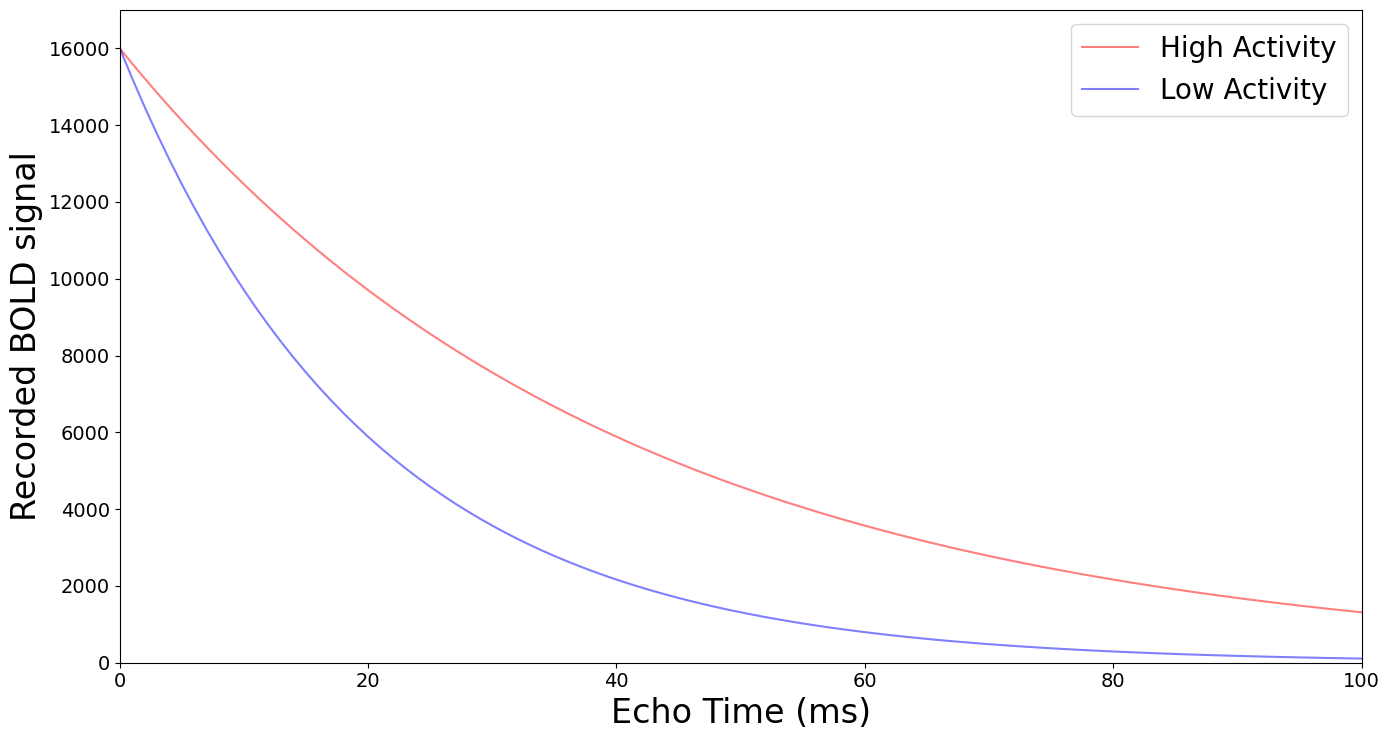

In [9]:
fullcurve_signal_active = predict_bold_signal(FULLCURVE_TES, [MEAN_S0], [40])
fullcurve_signal_inactive = predict_bold_signal(FULLCURVE_TES, [MEAN_S0], [20])

fig, ax = plt.subplots(figsize=(14, 7.5))
ax.plot(
    FULLCURVE_TES,
    fullcurve_signal_active[:, 0],
    alpha=0.5,
    color="red",
    label="High Activity",
)
ax.plot(
    FULLCURVE_TES,
    fullcurve_signal_inactive[:, 0],
    alpha=0.5,
    color="blue",
    label="Low Activity",
)

ax.set_ylabel("Recorded BOLD signal", fontsize=24)
ax.set_xlabel("Echo Time (ms)", fontsize=24)
ax.set_ylim(0, np.ceil(np.max(fullcurve_signal) / 1000) * 1000)
ax.set_xlim(0, np.max(FULLCURVE_TES))
ax.legend(fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()
glue("fig_signal_decay_contrast", fig, display=False)

```{glue:figure} fig_signal_decay_contrast
:name: fig_signal_decay_contrast
:align: center

BOLD signal decay and BOLD contrast
```

### Plot single-echo data resulting from $S_{0}$ and $T_{2}^{*}$ fluctuations

This shows how fMRI data fluctuates over time.

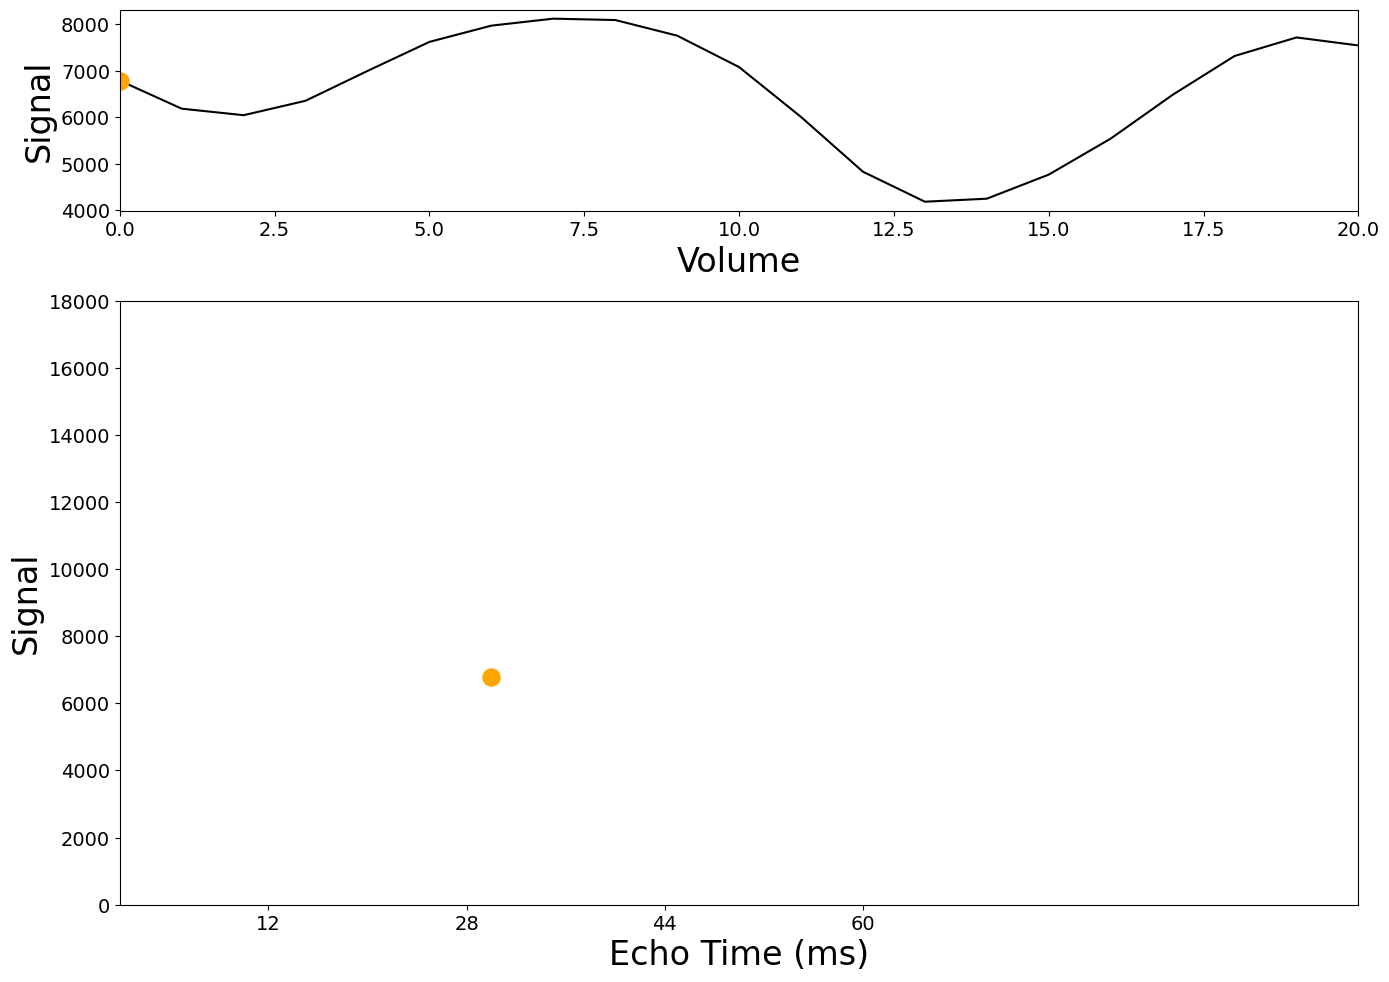

In [10]:
fullcurve_signal = predict_bold_signal(FULLCURVE_TES, s0_ts, t2s_ts)
singleecho_signal = fullcurve_signal[SINGLEECHO_TE, :]

# gif code based on https://www.geeksforgeeks.org/create-an-animated-gif-using-python-matplotlib/
fig, axes = plt.subplots(
    nrows=2, figsize=(14, 10), gridspec_kw={"height_ratios": [1, 3]}
)

# Set constant params for figure
axes[0].set_ylabel("Signal", fontsize=24)
axes[0].set_xlabel("Volume", fontsize=24)
axes[0].set_xlim(0, N_VOLS - 1)
axes[0].tick_params(axis="both", which="major", labelsize=14)
axes[1].set_ylabel("Signal", fontsize=24)
axes[1].set_xlabel("Echo Time (ms)", fontsize=24)
axes[1].set_xticks(ECHO_TIMES)
axes[1].set_ylim(0, np.ceil(np.max(fullcurve_signal) / 1000) * 1000)
axes[1].set_xlim(0, np.max(FULLCURVE_TES))
axes[1].tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()

ax0_line_plot = axes[0].plot(singleecho_signal[0, :], color="black", zorder=0)
ax0_scatter_plot = axes[0].scatter(
    0,
    singleecho_signal[:, 0],
    color="orange",
    s=150,
    label="Single-Echo Signal",
    zorder=1,
)
ax1_scatter_plot = axes[1].scatter(
    SINGLEECHO_TE,
    singleecho_signal[:, 0],
    color="orange",
    s=150,
    alpha=1.0,
    label="Single-Echo Signal",
    zorder=1,
)


def AnimationFunction(frame):
    """Function takes frame as an input."""
    ax0_scatter_plot.set_offsets(
        np.column_stack(
            (
                frame,
                singleecho_signal[:, frame],
            )
        )
    )

    ax1_scatter_plot.set_offsets(
        np.column_stack(
            (
                SINGLEECHO_TE,
                singleecho_signal[:, frame],
            )
        )
    )


anim_created = FuncAnimation(fig, AnimationFunction, frames=N_VOLS, interval=100)
html = display.HTML(anim_created.to_jshtml())
glue("fig_single-echo", html, display=False)

```{glue:figure} fig_single-echo
:name: fig_single-echo
:align: center

Single-echo data resulting from $S_{0}$ and $T_{2}^{*}$ fluctuations
```

### Plot single-echo data and the curve resulting from $S_{0}$ and $T_{2}^{*}$ fluctuations

This shows how single-echo data is a sample from a signal decay curve.

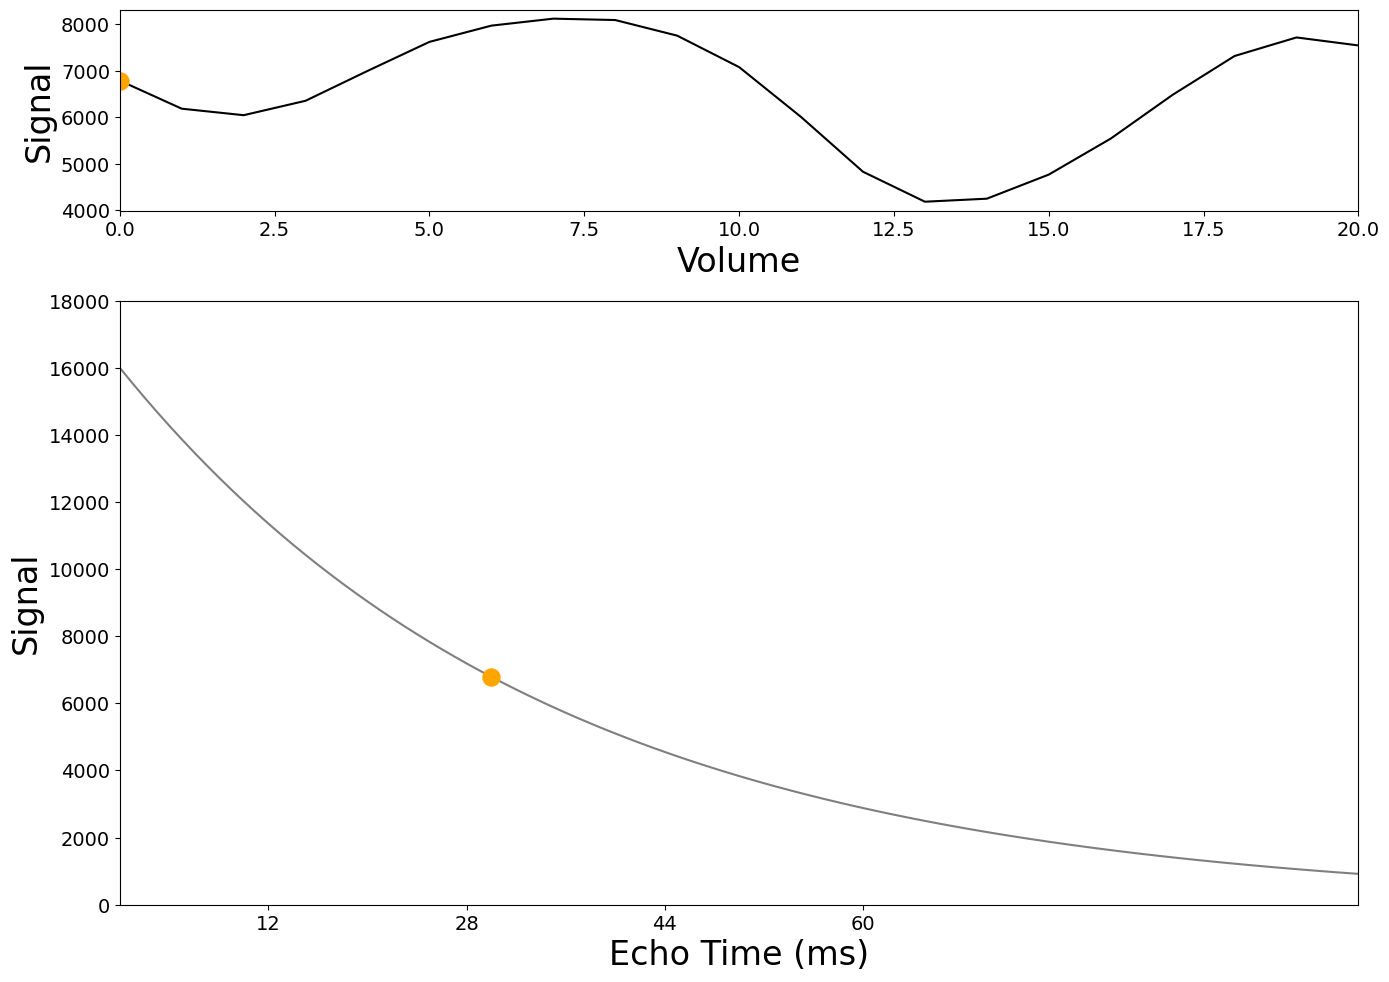

In [11]:
fullcurve_signal = predict_bold_signal(FULLCURVE_TES, s0_ts, t2s_ts)
singleecho_signal = fullcurve_signal[SINGLEECHO_TE, :]

# gif code based on https://www.geeksforgeeks.org/create-an-animated-gif-using-python-matplotlib/
fig, axes = plt.subplots(
    nrows=2, figsize=(14, 10), gridspec_kw={"height_ratios": [1, 3]}
)

# Set constant params for figure
axes[0].set_ylabel("Signal", fontsize=24)
axes[0].set_xlabel("Volume", fontsize=24)
axes[0].set_xlim(0, N_VOLS - 1)
axes[0].tick_params(axis="both", which="major", labelsize=14)
axes[1].set_ylabel("Signal", fontsize=24)
axes[1].set_xlabel("Echo Time (ms)", fontsize=24)
axes[1].set_xticks(ECHO_TIMES)
axes[1].set_ylim(0, np.ceil(np.max(fullcurve_signal) / 1000) * 1000)
axes[1].set_xlim(0, np.max(FULLCURVE_TES))
axes[1].tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()

ax0_line_plot = axes[0].plot(singleecho_signal[0, :], color="black", zorder=0)
ax0_scatter_plot = axes[0].scatter(
    0,
    singleecho_signal[:, 0],
    color="orange",
    s=150,
    label="Single-Echo Signal",
    zorder=1,
)
ax1_line_plot = axes[1].plot(
    FULLCURVE_TES,
    fullcurve_signal[:, 0],
    alpha=0.5,
    color="black",
    zorder=0,
)[0]
ax1_scatter_plot = axes[1].scatter(
    SINGLEECHO_TE,
    singleecho_signal[:, 0],
    color="orange",
    s=150,
    alpha=1.0,
    label="Single-Echo Signal",
    zorder=1,
)


def AnimationFunction(frame):
    """Function takes frame as an input."""
    ax0_scatter_plot.set_offsets(
        np.column_stack(
            (
                frame,
                singleecho_signal[:, frame],
            )
        )
    )

    ax1_line_plot.set_data(
        (
            FULLCURVE_TES,
            fullcurve_signal[:, frame],
        )
    )
    ax1_scatter_plot.set_offsets(
        np.column_stack(
            (
                SINGLEECHO_TE,
                singleecho_signal[:, frame],
            )
        )
    )


anim_created = FuncAnimation(fig, AnimationFunction, frames=N_VOLS, interval=100)
html = display.HTML(anim_created.to_jshtml())
glue("fig_signal_decay", html, display=False)

```{glue:figure} fig_signal_decay
:name: fig_signal_decay
:align: center

Single-echo data and the curve resulting from $S_{0}$ and $T_{2}^{*}$ fluctuations
```

### Plot single-echo data, the curve, and the $S_{0}$ and $T_{2}^{*}$ values resulting from $S_{0}$ and $T_{2}^{*}$ fluctuations

This shows how changes in fMRI data can be driven by both S0 and T2* fluctuations.

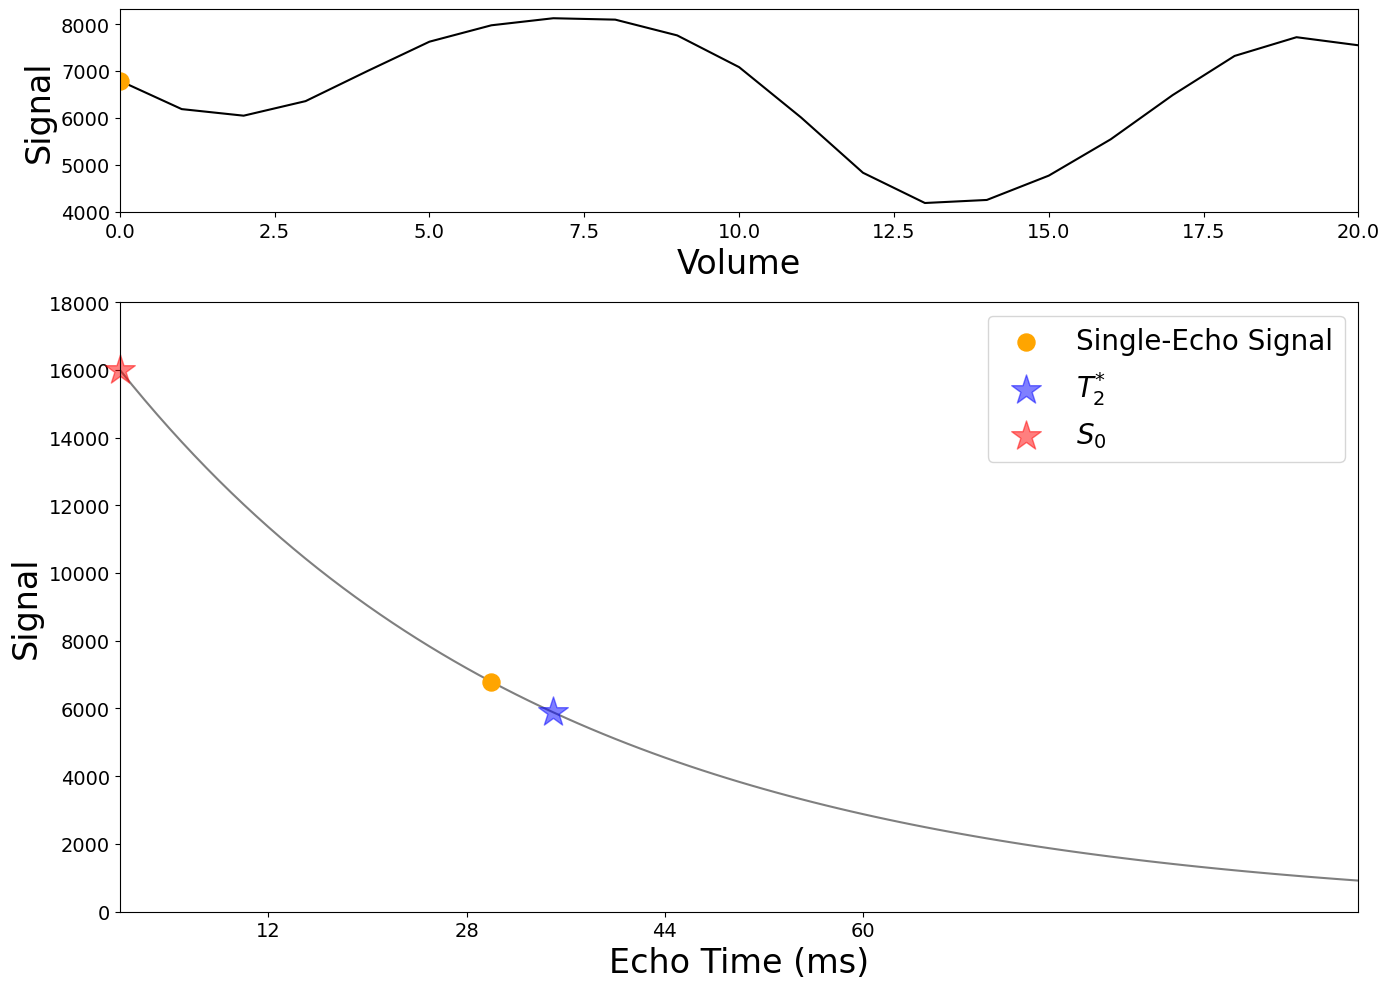

In [12]:
fullcurve_signal = predict_bold_signal(FULLCURVE_TES, s0_ts, t2s_ts)
singleecho_signal = fullcurve_signal[SINGLEECHO_TE, :]

fig, axes = plt.subplots(
    nrows=2, figsize=(14, 10), gridspec_kw={"height_ratios": [1, 3]}
)

t2s_value = predict_bold_signal(
    np.array([t2s_ts[0]]), np.array([s0_ts[0]]), np.array([t2s_ts[0]])
)[0]

ax0_line_plot = axes[0].plot(singleecho_signal[0, :], color="black", zorder=0)
ax0_scatter_plot = axes[0].scatter(
    0,
    singleecho_signal[:, 0],
    color="orange",
    s=150,
    label="Single-Echo Signal",
    zorder=1,
)
ax1_line_plot = axes[1].plot(
    FULLCURVE_TES,
    fullcurve_signal[:, 0],
    alpha=0.5,
    color="black",
    zorder=0,
)[0]
ax1_scatter_plot = axes[1].scatter(
    SINGLEECHO_TE,
    singleecho_signal[:, 0],
    color="orange",
    s=150,
    alpha=1.0,
    label="Single-Echo Signal",
    zorder=1,
)
ax1_t2s_scatter_plot = axes[1].scatter(
    t2s_ts[0],
    t2s_value,
    marker="*",
    color="blue",
    s=500,
    alpha=0.5,
    label="$T_{2}^{*}$",
    zorder=1,
)
ax1_s0_scatter_plot = axes[1].scatter(
    0,
    s0_ts[0],
    marker="*",
    color="red",
    s=500,
    alpha=0.5,
    label="$S_{0}$",
    clip_on=False,
    zorder=2,
)

# Set constant params for figure
axes[0].set_ylabel("Signal", fontsize=24)
axes[0].set_xlabel("Volume", fontsize=24)
axes[0].set_xlim(0, N_VOLS - 1)
axes[0].tick_params(axis="both", which="major", labelsize=14)
axes[1].legend(loc="upper right", fontsize=20)
axes[1].set_ylabel("Signal", fontsize=24)
axes[1].set_xlabel("Echo Time (ms)", fontsize=24)
axes[1].set_xticks(ECHO_TIMES)
axes[1].set_ylim(0, np.ceil(np.max(fullcurve_signal) / 1000) * 1000)
axes[1].set_xlim(0, np.max(FULLCURVE_TES))
axes[1].tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()


def AnimationFunction(frame):
    """Function takes frame as an input."""
    t2s_value = predict_bold_signal(
        np.array([t2s_ts[frame]]), np.array([s0_ts[frame]]), np.array([t2s_ts[frame]])
    )[0]

    ax0_scatter_plot.set_offsets(
        np.column_stack(
            (
                frame,
                singleecho_signal[:, frame],
            )
        )
    )

    ax1_line_plot.set_data(
        (
            FULLCURVE_TES,
            fullcurve_signal[:, frame],
        )
    )
    ax1_scatter_plot.set_offsets(
        np.column_stack(
            (
                SINGLEECHO_TE,
                singleecho_signal[:, frame],
            )
        )
    )
    ax1_t2s_scatter_plot.set_offsets(
        np.column_stack(
            (
                t2s_ts[frame],
                t2s_value,
            )
        )
    )
    ax1_s0_scatter_plot.set_offsets(
        np.column_stack(
            (
                0,
                s0_ts[frame],
            )
        )
    )


anim_created = FuncAnimation(fig, AnimationFunction, frames=N_VOLS, interval=100)
html = display.HTML(anim_created.to_jshtml())
glue("fig_signal_decay2", html, display=False)

```{glue:figure} fig_signal_decay2
:name: fig_signal_decay2
:align: center

Single-echo data, the curve, and the $S_{0}$ and $T_{2}^{*}$ values resulting from $S_{0}$ and $T_{2}^{*}$ fluctuations
```

### Plot $S_{0}$ and $T_{2}^{*}$ fluctuations

This shows how fluctuations in S0 and T2* produce different patterns in the full signal decay curves.

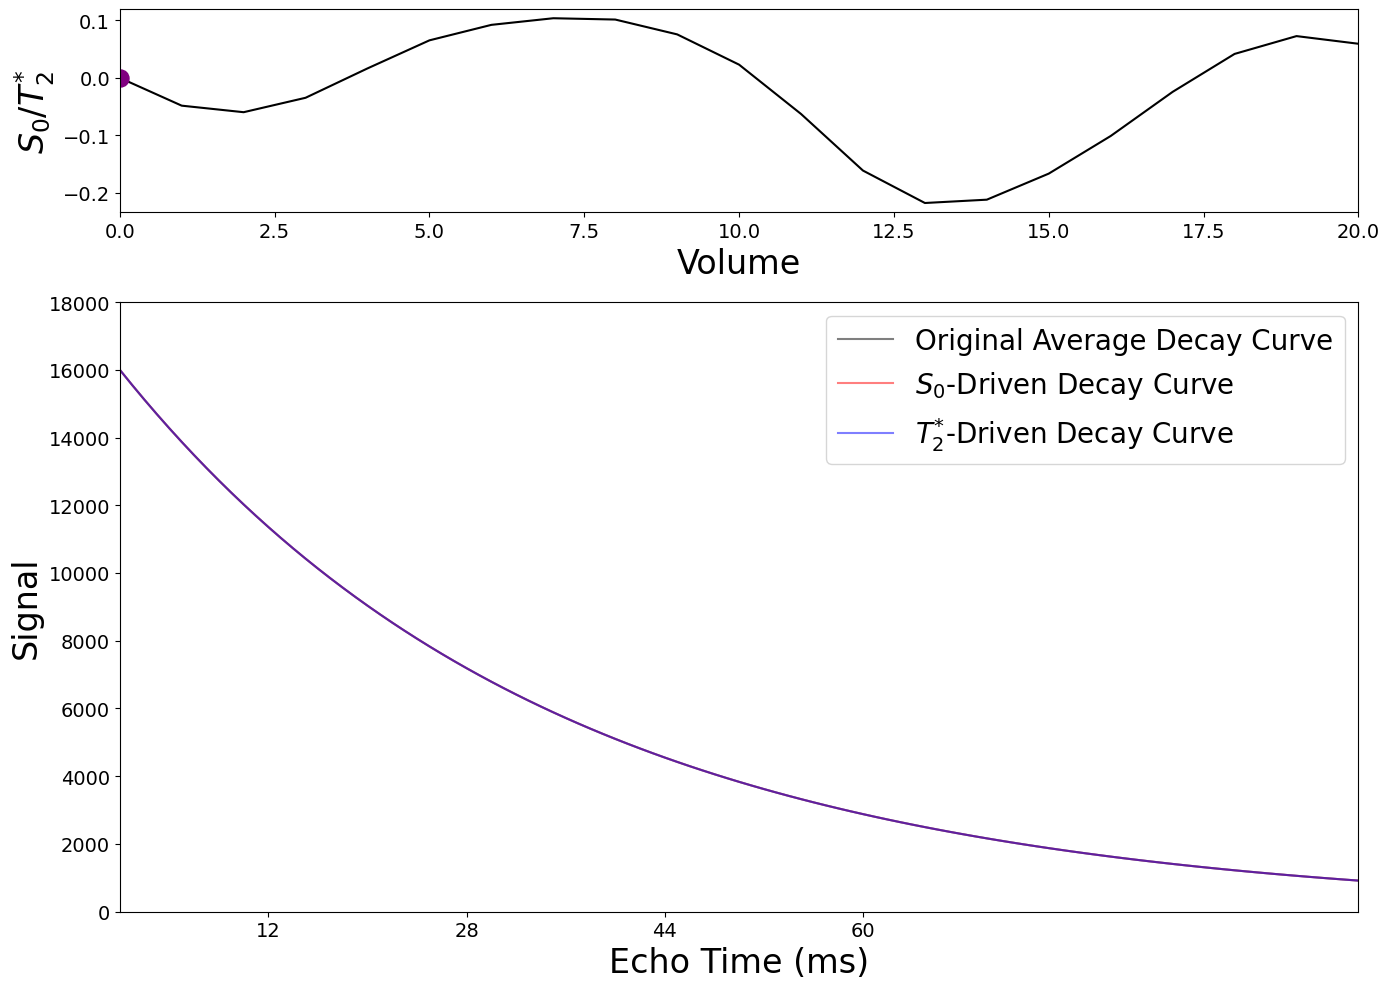

In [13]:
s0based_fullcurve_signal = predict_bold_signal(
    FULLCURVE_TES, s0_ts, np.full(N_VOLS, MEAN_T2S)
)
t2sbased_fullcurve_signal = predict_bold_signal(
    FULLCURVE_TES, np.full(N_VOLS, MEAN_S0), t2s_ts
)
unperturbed_fullcurve_signal = np.mean(
    (s0based_fullcurve_signal[:, 0], t2sbased_fullcurve_signal[:, 0]),
    axis=0,
)

fig, axes = plt.subplots(
    nrows=2, figsize=(14, 10), gridspec_kw={"height_ratios": [1, 3]}
)

t2s_value = predict_bold_signal(
    np.array([t2s_ts[0]]), np.array([s0_ts[0]]), np.array([t2s_ts[0]])
)[0]

ax0_line_plot = axes[0].plot(ts, color="black", zorder=0)
ax0_scatter_plot = axes[0].scatter(
    0,
    ts[0],
    color="purple",
    s=150,
    label="Single-Echo Signal",
    zorder=1,
)
ax1_orig_line_plot = axes[1].plot(
    FULLCURVE_TES,
    unperturbed_fullcurve_signal,
    alpha=0.5,
    color="black",
    label="Original Average Decay Curve",
    zorder=-1,
)[0]
ax1_s0_line_plot = axes[1].plot(
    FULLCURVE_TES,
    s0based_fullcurve_signal[:, 0],
    alpha=0.5,
    color="red",
    label="$S_0$-Driven Decay Curve",
)[0]
ax1_t2s_line_plot = axes[1].plot(
    FULLCURVE_TES,
    t2sbased_fullcurve_signal[:, 0],
    alpha=0.5,
    color="blue",
    label="$T_{2}^{*}$-Driven Decay Curve",
)[0]

# Set constant params for figure
axes[0].set_ylabel("$S_0$/$T_{2}^{*}$", fontsize=24)
axes[0].set_xlabel("Volume", fontsize=24)
axes[0].set_xlim(0, N_VOLS - 1)
axes[0].tick_params(axis="both", which="major", labelsize=14)
axes[1].legend(loc="upper right", fontsize=20)
axes[1].set_ylabel("Signal", fontsize=24)
axes[1].set_xlabel("Echo Time (ms)", fontsize=24)
axes[1].set_xticks(ECHO_TIMES)
axes[1].set_ylim(0, np.ceil(np.max(s0based_fullcurve_signal) / 1000) * 1000)
axes[1].set_xlim(0, np.max(FULLCURVE_TES))
axes[1].tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()


def AnimationFunction(frame):
    """Function takes frame as an input."""
    ax0_scatter_plot.set_offsets(
        np.column_stack(
            (
                frame,
                ts[frame],
            )
        )
    )

    ax1_t2s_line_plot.set_data(
        (
            FULLCURVE_TES,
            t2sbased_fullcurve_signal[:, frame],
        )
    )
    ax1_s0_line_plot.set_data(
        (
            FULLCURVE_TES,
            s0based_fullcurve_signal[:, frame],
        )
    )


anim_created = FuncAnimation(fig, AnimationFunction, frames=N_VOLS, interval=100)
html = display.HTML(anim_created.to_jshtml())
glue("fig_signal_decay3", html, display=False)

```{glue:figure} fig_signal_decay3
:name: fig_signal_decay3
:align: center

$S_{0}$ and $T_{2}^{*}$ fluctuations
```

### Plot $S_{0}$ and $T_{2}^{*}$ fluctuations and resulting single-echo data

This shows how single-echo data, on its own, cannot distinguish between S0 and T2* fluctuations.

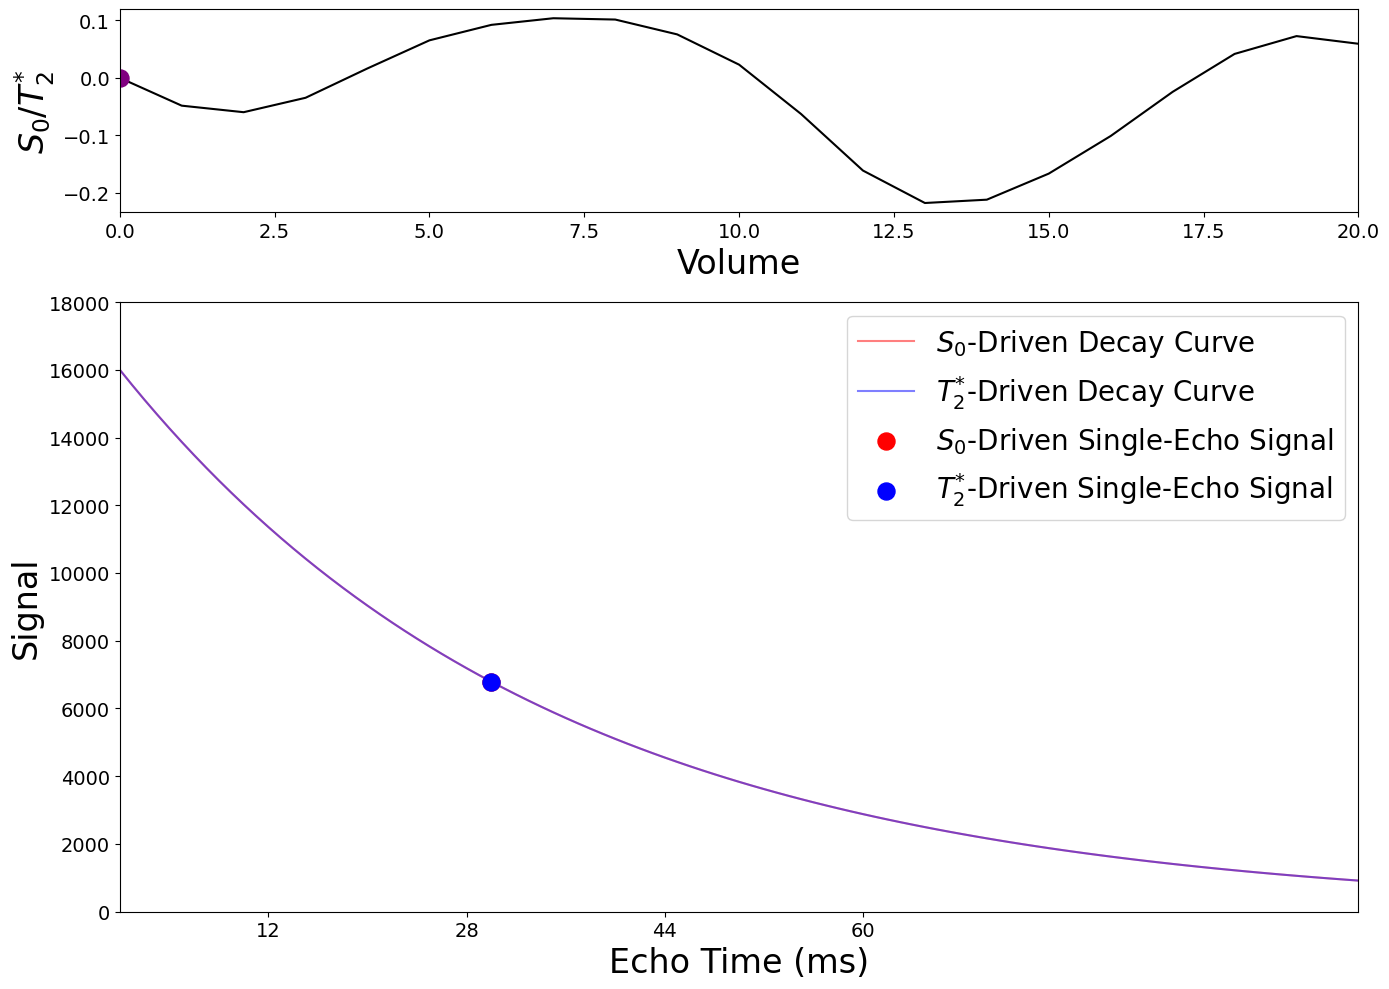

In [14]:
s0based_fullcurve_signal = predict_bold_signal(
    FULLCURVE_TES, s0_ts, np.full(N_VOLS, MEAN_T2S)
)
t2sbased_fullcurve_signal = predict_bold_signal(
    FULLCURVE_TES, np.full(N_VOLS, MEAN_S0), t2s_ts
)
s0based_singleecho_signal = s0based_fullcurve_signal[SINGLEECHO_TE, :]
t2sbased_singleecho_signal = t2sbased_fullcurve_signal[SINGLEECHO_TE, :]

fig, axes = plt.subplots(
    nrows=2, figsize=(14, 10), gridspec_kw={"height_ratios": [1, 3]}
)

ax0_line_plot = axes[0].plot(ts, color="black", zorder=0)
ax0_scatter_plot = axes[0].scatter(
    0,
    ts[0],
    color="purple",
    s=150,
    zorder=1,
)
ax1_s0_line_plot = axes[1].plot(
    FULLCURVE_TES,
    s0based_fullcurve_signal[:, 0],
    color="red",
    alpha=0.5,
    label="$S_0$-Driven Decay Curve",
    zorder=0,
)[0]
ax1_t2s_line_plot = axes[1].plot(
    FULLCURVE_TES,
    t2sbased_fullcurve_signal[:, 0],
    color="blue",
    alpha=0.5,
    label="$T_{2}^{*}$-Driven Decay Curve",
    zorder=1,
)[0]
ax1_s0_scatter_plot = axes[1].scatter(
    SINGLEECHO_TE,
    s0based_singleecho_signal[:, 0],
    color="red",
    s=150,
    alpha=1.0,
    label="$S_0$-Driven Single-Echo Signal",
    zorder=2,
)
ax1_t2s_scatter_plot = axes[1].scatter(
    SINGLEECHO_TE,
    t2sbased_singleecho_signal[:, 0],
    color="blue",
    s=150,
    alpha=1.0,
    label="$T_{2}^{*}$-Driven Single-Echo Signal",
    zorder=3,
)

# Set constant params for figure
axes[0].set_ylabel("$S_0$/$T_{2}^{*}$", fontsize=24)
axes[0].set_xlabel("Volume", fontsize=24)
axes[0].set_xlim(0, N_VOLS - 1)
axes[0].tick_params(axis="both", which="major", labelsize=14)
axes[1].legend(loc="upper right", fontsize=20)
axes[1].set_ylabel("Signal", fontsize=24)
axes[1].set_xlabel("Echo Time (ms)", fontsize=24)
axes[1].set_xticks(ECHO_TIMES)
axes[1].set_ylim(0, np.ceil(np.max(s0based_fullcurve_signal) / 1000) * 1000)
axes[1].set_xlim(0, np.max(FULLCURVE_TES))
axes[1].tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()


def AnimationFunction(frame):
    """Function takes frame as an input."""
    ax0_scatter_plot.set_offsets(
        np.column_stack(
            (
                frame,
                ts[frame],
            )
        )
    )

    ax1_s0_line_plot.set_data(
        (
            FULLCURVE_TES,
            s0based_fullcurve_signal[:, frame],
        )
    )
    ax1_t2s_line_plot.set_data(
        (
            FULLCURVE_TES,
            t2sbased_fullcurve_signal[:, frame],
        )
    )
    ax1_s0_scatter_plot.set_offsets(
        np.column_stack(
            (
                SINGLEECHO_TE,
                s0based_singleecho_signal[:, frame],
            )
        )
    )
    ax1_t2s_scatter_plot.set_offsets(
        np.column_stack(
            (
                SINGLEECHO_TE,
                t2sbased_singleecho_signal[:, frame],
            )
        )
    )


anim_created = FuncAnimation(fig, AnimationFunction, frames=N_VOLS, interval=100)
html = display.HTML(anim_created.to_jshtml())
glue("fig_signal_decay4", html, display=False)

```{glue:figure} fig_signal_decay4
:name: fig_signal_decay4
:align: center

$S_{0}$ and $T_{2}^{*}$ fluctuations and resulting single-echo data
```

### Plot $S_{0}$ and $T_{2}^{*}$ fluctuations and resulting multi-echo data

This shows how S0 and T2* fluctuations produce different patterns in multi-echo data.

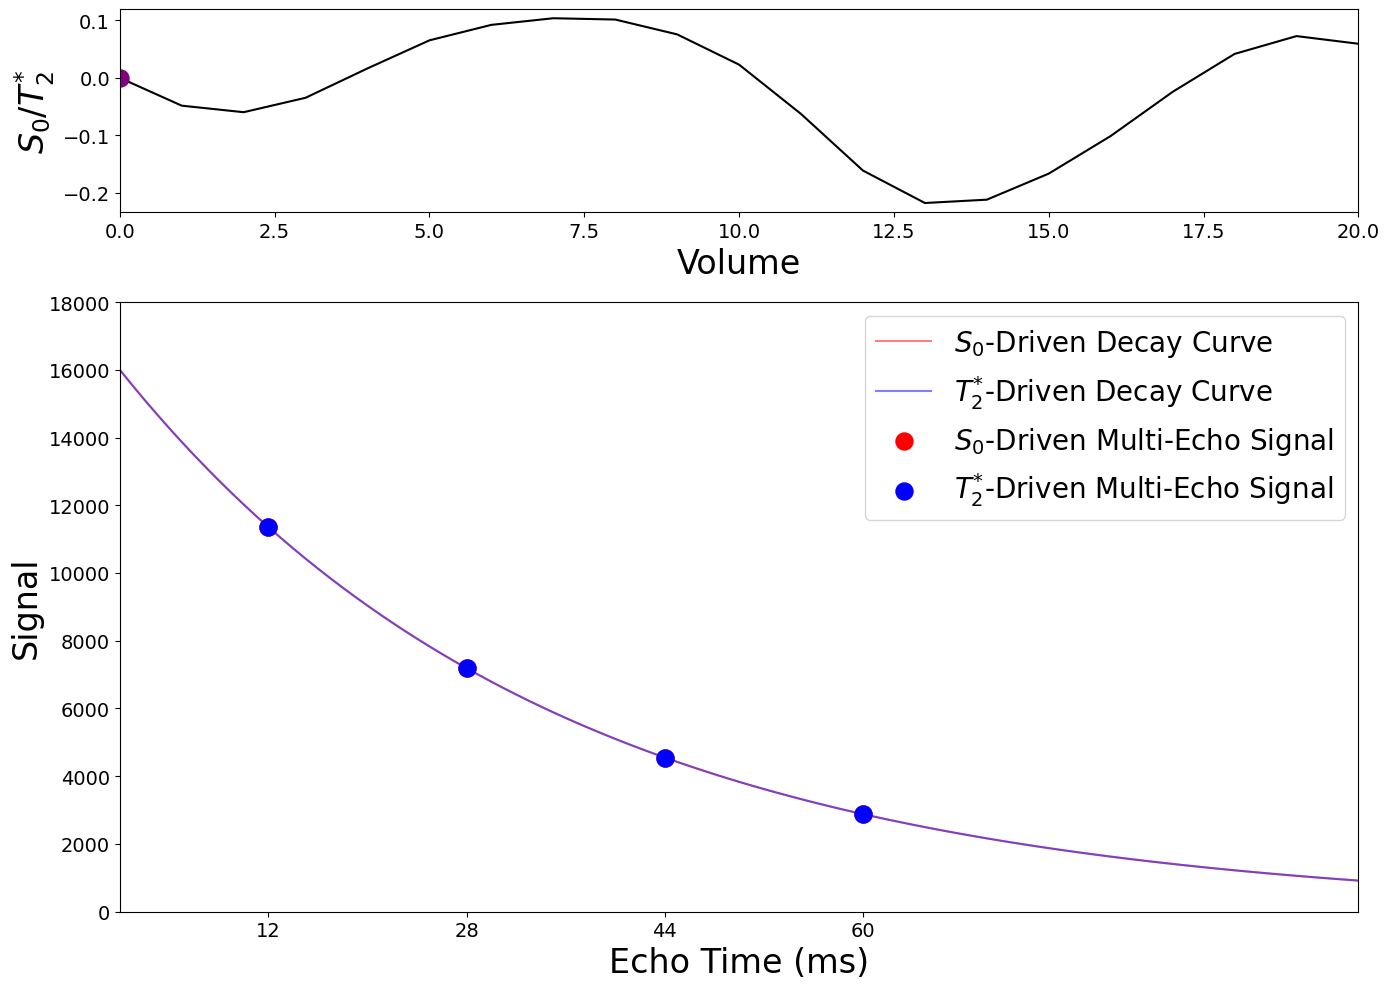

In [15]:
s0based_fullcurve_signal = predict_bold_signal(
    FULLCURVE_TES, s0_ts, np.full(N_VOLS, MEAN_T2S)
)
t2sbased_fullcurve_signal = predict_bold_signal(
    FULLCURVE_TES, np.full(N_VOLS, MEAN_S0), t2s_ts
)
s0based_multiecho_signal = s0based_fullcurve_signal[ECHO_TIMES, :]
t2sbased_multiecho_signal = t2sbased_fullcurve_signal[ECHO_TIMES, :]

fig, axes = plt.subplots(
    nrows=2, figsize=(14, 10), gridspec_kw={"height_ratios": [1, 3]}
)

ax0_line_plot = axes[0].plot(
    ts,
    color="black",
    zorder=0,
)[0]
ax0_scatter_plot = axes[0].scatter(
    0,
    ts[0],
    color="purple",
    s=150,
    zorder=1,
)
ax1_s0_line_plot = axes[1].plot(
    FULLCURVE_TES,
    s0based_fullcurve_signal[:, 0],
    color="red",
    alpha=0.5,
    label="$S_0$-Driven Decay Curve",
    zorder=0,
)[0]
ax1_t2s_line_plot = axes[1].plot(
    FULLCURVE_TES,
    t2sbased_fullcurve_signal[:, 0],
    color="blue",
    alpha=0.5,
    label="$T_{2}^{*}$-Driven Decay Curve",
    zorder=1,
)[0]
ax1_s0_scatter_plot = axes[1].scatter(
    ECHO_TIMES,
    s0based_multiecho_signal[:, 0],
    color="red",
    s=150,
    alpha=1.0,
    label="$S_0$-Driven Multi-Echo Signal",
    zorder=2,
)
ax1_t2s_scatter_plot = axes[1].scatter(
    ECHO_TIMES,
    t2sbased_multiecho_signal[:, 0],
    color="blue",
    s=150,
    alpha=1.0,
    label="$T_{2}^{*}$-Driven Multi-Echo Signal",
    zorder=3,
)

axes[0].set_ylabel("$S_0$/$T_{2}^{*}$", fontsize=24)
axes[0].set_xlabel("Volume", fontsize=24)
axes[0].set_xlim(0, N_VOLS - 1)
axes[0].tick_params(axis="both", which="major", labelsize=14)
axes[1].legend(loc="upper right", fontsize=20)
axes[1].set_ylabel("Signal", fontsize=24)
axes[1].set_xlabel("Echo Time (ms)", fontsize=24)
axes[1].set_xticks(ECHO_TIMES)
axes[1].set_ylim(0, np.ceil(np.max(s0based_fullcurve_signal) / 1000) * 1000)
axes[1].set_xlim(0, np.max(FULLCURVE_TES))
axes[1].tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()


def AnimationFunction(frame):
    """Function takes frame as an input."""
    ax0_scatter_plot.set_offsets(
        np.column_stack(
            (
                frame,
                ts[frame],
            )
        )
    )

    ax1_s0_line_plot.set_data(
        (
            FULLCURVE_TES,
            s0based_fullcurve_signal[:, frame],
        )
    )
    ax1_t2s_line_plot.set_data(
        (
            FULLCURVE_TES,
            t2sbased_fullcurve_signal[:, frame],
        )
    )
    ax1_s0_scatter_plot.set_offsets(
        np.column_stack(
            (
                ECHO_TIMES,
                s0based_multiecho_signal[:, frame],
            )
        )
    )
    ax1_t2s_scatter_plot.set_offsets(
        np.column_stack(
            (
                ECHO_TIMES,
                t2sbased_multiecho_signal[:, frame],
            )
        )
    )


anim_created = FuncAnimation(fig, AnimationFunction, frames=N_VOLS, interval=100)
html = display.HTML(anim_created.to_jshtml())
glue("fig_signal_decay5", html, display=False)

```{glue:figure} fig_signal_decay5
:name: fig_signal_decay5
:align: center

$S_{0}$ and $T_{2}^{*}$ fluctuations and resulting multi-echo data
```

#### Plot $T_{2}^{*}$ against BOLD signal from single-echo data (TE=30ms)

When the BOLD signal is driven entirely by T2* fluctuations,
the BOLD signal is very similar to a scaled version of those T2* fluctuations, but there are small differences.

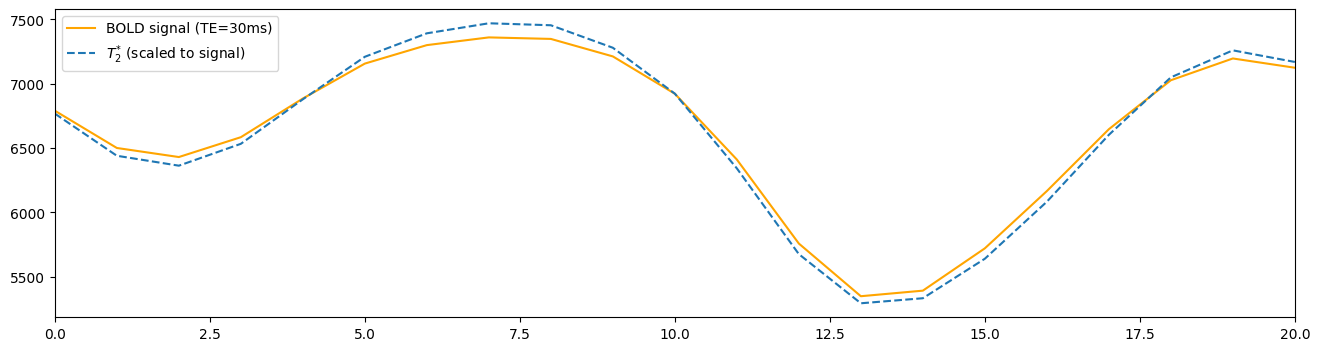

In [16]:
fig, ax = plt.subplots(figsize=(16, 4))

scalar = np.linalg.lstsq(
    t2s_ts[:, None], t2sbased_fullcurve_signal[SINGLEECHO_TE[0], :], rcond=None
)[0]
ax.plot(
    t2sbased_fullcurve_signal[SINGLEECHO_TE[0], :],
    color="orange",
    label=f"BOLD signal (TE={SINGLEECHO_TE[0]}ms)",
)
ax.plot(
    t2s_ts * scalar,
    label="$T_{2}^{*}$ (scaled to signal)",
    linestyle="--",
)
ax.set_xlim(0, N_VOLS - 1)
leg = ax.legend()
glue("fig_t2s_bold_single-echo", fig, display=False)

```{glue:figure} fig_t2s_bold_single-echo
:name: fig_t2s_bold_single-echo
:align: center

$T_{2}^{*}$ against BOLD signal from single-echo data (TE=30ms)
```

#### Plot $S_{0}$ against BOLD signal from single-echo data (TE=30ms)

When the BOLD signal is driven entirely by S0 fluctuations, the BOLD signal ends up being a scaled version of the S0 fluctuations.

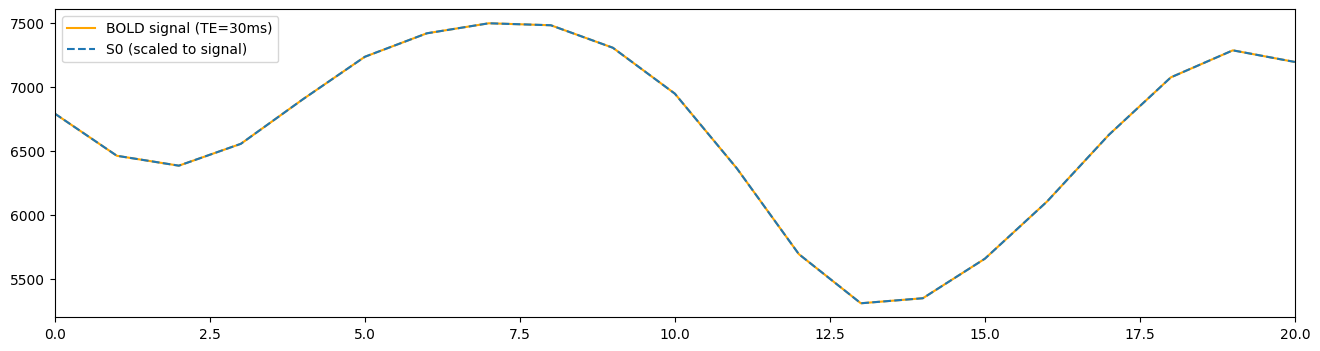

In [17]:
fig, ax = plt.subplots(figsize=(16, 4))

scalar = np.linalg.lstsq(
    s0_ts[:, None], s0based_fullcurve_signal[SINGLEECHO_TE[0], :], rcond=None
)[0]
ax.plot(
    s0based_fullcurve_signal[SINGLEECHO_TE[0], :],
    color="orange",
    label=f"BOLD signal (TE={SINGLEECHO_TE[0]}ms)",
)
ax.plot(
    s0_ts * scalar,
    label="S0 (scaled to signal)",
    linestyle="--",
)
ax.set_xlim(0, N_VOLS - 1)
leg = ax.legend()
glue("fig_s0_bold_single-echo", fig, display=False)

```{glue:figure} fig_s0_bold_single-echo
:name: fig_s0_bold_single-echo
:align: center

$S_{0}$ against BOLD signal from single-echo data (TE=30ms)
```